In [2]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

### Load model

In [3]:
name = "overdamped_k15"

overdamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
overdamped_name = f"model_{name}.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

15 True True False [128, 128, 256]


### Problem definition

In [4]:
N = 512
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [5]:
H_dict = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [6]:
w_list_transfer = [1, 1, 1, 1, 1]
zeta_list = [5, 10, 30, 60]

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.cos(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.cos(t)), axis=1)
    return force

forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

forcing_1D = lambda t: np.cos(t)
ic_list = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
epsilon_list = [0.5, 0.5, 0.5, 0.5, 0.5]
p_list = [6]
q = [(3, 1)]

### Numerical solver

In [7]:
numerical_list = []

for zeta in zeta_list:
    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta, forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
    numerical_list.append(numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0]))

### PINN

In [8]:
NN_TL_solution, perturbation_solution, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution = NN_TL_solution.squeeze()

In [9]:
NN_TL_solution.shape

(512, 4, 2)

In [10]:
PINN_solution = []

for perturbation_zeta in perturbation_solution:

    perturbation = []
    for perturbation_order in perturbation_zeta:

        perturbation.append(perturbation_order[:, 0])

    PINN_solution.append(standard.calculate_general_series(perturbation, epsilon_list[0]))

zeta: 5, order: 0, mean error absolute: 0.07257264330743177
zeta: 5, order: 1, mean error absolute: 0.016586916029591333
zeta: 5, order: 2, mean error absolute: 0.005221626326257318
zeta: 5, order: 3, mean error absolute: 0.0014156293299512918
zeta: 5, order: 4, mean error absolute: 0.0008586293260226535
zeta: 5, order: 5, mean error absolute: 0.0001886455380913882


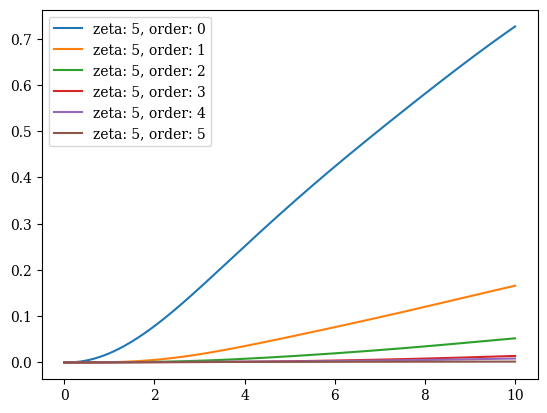

zeta: 10, order: 0, mean error absolute: 0.060409970661100175
zeta: 10, order: 1, mean error absolute: 0.009697388552978229
zeta: 10, order: 2, mean error absolute: 0.0019850607801069975
zeta: 10, order: 3, mean error absolute: 0.00043238607438021606
zeta: 10, order: 4, mean error absolute: 0.00017002136400061504
zeta: 10, order: 5, mean error absolute: 5.72279693000072e-05


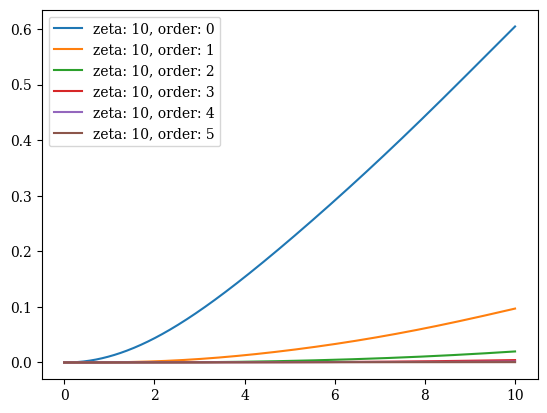

zeta: 30, order: 0, mean error absolute: 0.03157792931182653
zeta: 30, order: 1, mean error absolute: 0.0023168928615809508
zeta: 30, order: 2, mean error absolute: 0.00018114420921393052
zeta: 30, order: 3, mean error absolute: 0.0001013714113289781
zeta: 30, order: 4, mean error absolute: 8.000018009763558e-05
zeta: 30, order: 5, mean error absolute: 8.217672501543006e-05


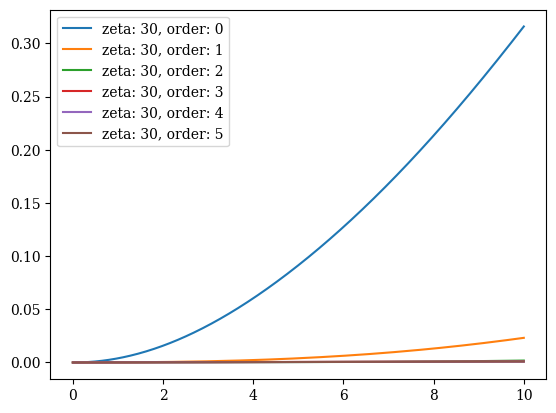

zeta: 60, order: 0, mean error absolute: 0.01814645548091587
zeta: 60, order: 1, mean error absolute: 0.0007243141502467063
zeta: 60, order: 2, mean error absolute: 3.385767643825045e-05
zeta: 60, order: 3, mean error absolute: 2.5748891472440706e-05
zeta: 60, order: 4, mean error absolute: 2.3822157645668387e-05
zeta: 60, order: 5, mean error absolute: 2.3931405463943492e-05


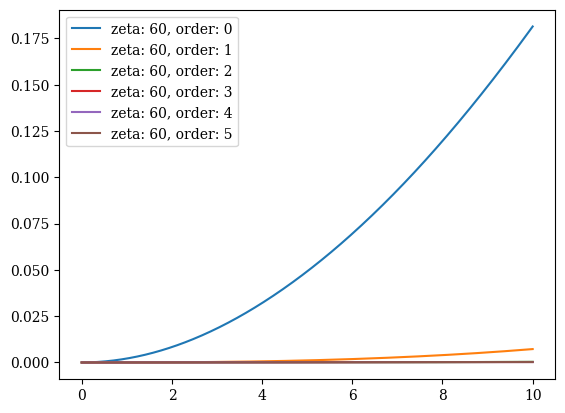

In [11]:
standard.plot_error_by_order(t_eval, PINN_solution, numerical_list, p_list, zeta_list, "zeta")

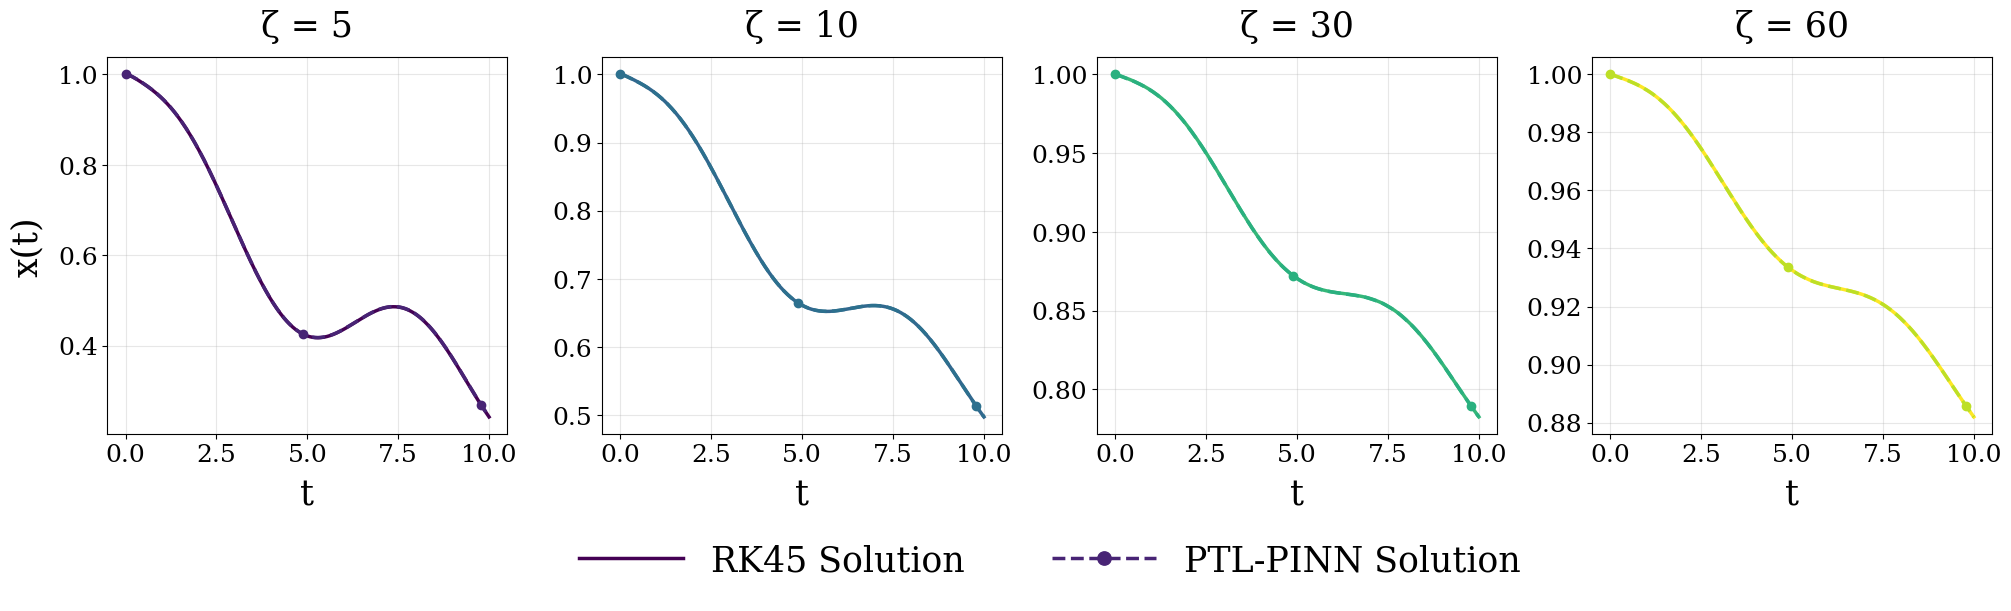

In [12]:
standard.plot_compare_multiple_zeta(t_eval, zeta_list, numerical_list, NN_TL_solution)


zeta: 5, mean Error: 3.852e-04
zeta: 10, mean Error: 7.237e-05
zeta: 30, mean Error: 8.193e-05
zeta: 60, mean Error: 2.392e-05


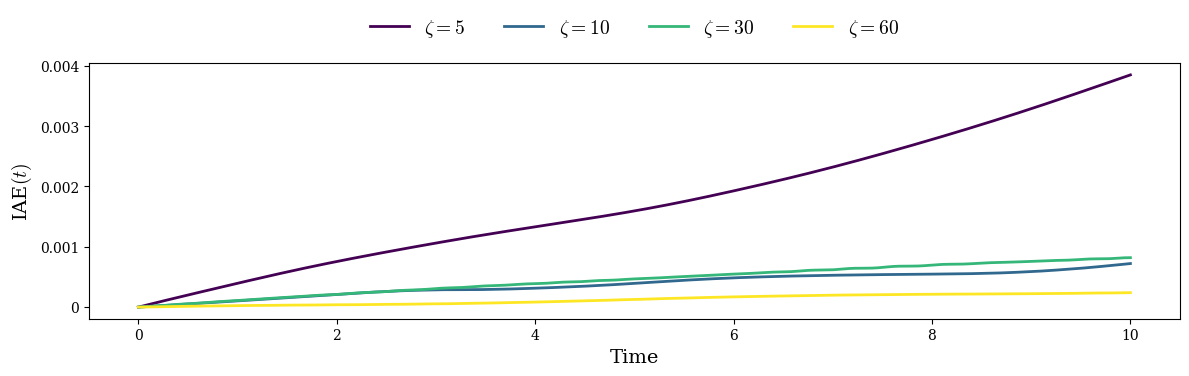

In [13]:
standard.plot_IAE_multiple_zeta(zeta_list, t_eval, NN_TL_solution, numerical_list)

/tmp/ipykernel_89049/2572481309.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", 3)


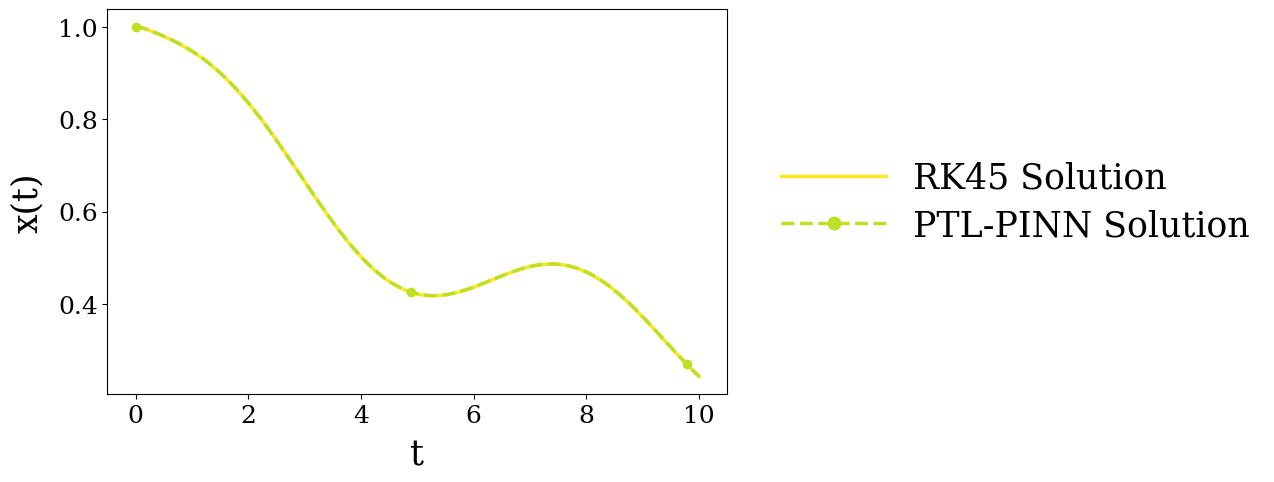

In [14]:
import matplotlib.cm as cm

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",
    "text.usetex": False,
})

def plot_solution(t_eval, y_num, y_nn, i = 3):
    title_fs  = 25
    label_fs  = 25
    tick_fs   = 18
    legend_fs = 25
    cmap = cm.get_cmap("viridis", 3)

    fig, ax = plt.subplots(figsize=(8, 5))

    base_color = cmap(i / 2)
    rk_color   = base_color
    pinn_color = cm.viridis(0.1 + 0.8 * i / 2)

    ax.plot(t_eval, y_num,
            label="RK45 Solution",
            color=rk_color, linewidth=2.5)

    ax.plot(t_eval, y_nn,
            label="PTL-PINN Solution",
            color=pinn_color, linewidth=2.5,
            linestyle="--", marker="o", markevery=250)

    ax.set_xlabel("t", fontsize=label_fs, labelpad=8)
    ax.set_ylabel("x(t)", fontsize=label_fs, labelpad=10)

    ax.tick_params(axis='both', labelsize=tick_fs)

    # Set y-limits with padding
    y_min = min(np.min(y_num), np.min(y_nn))
    y_max = max(np.max(y_num), np.max(y_nn))
    pad = 0.05 * max(1e-12, (y_max - y_min))
    ax.set_ylim(y_min - pad, y_max + pad)

    ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # (x, y): anchor the legend outside the right border
    fontsize=legend_fs,
    frameon=False,
    handlelength=3.0,
    markerscale=1.5,
    labelspacing=0.4,
    borderaxespad=0.8)
    plt.show()

plot_solution(t_eval, numerical_list[0][0, :], NN_TL_solution[:, 0, 0], i = 2)

In [15]:
ode_high_acc = equations.ode_oscillator_1D(w_0=1, zeta=zeta_list[0], forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
dt = (t_eval[1] - t_eval[0])/100
t_eval_high_acc = np.linspace(t_span[0], t_span[1], (t_eval.size - 1)*100 + 1)
num_high_acc = numerical.solve_ode_equation(ode_high_acc, (t_eval_high_acc[0], t_eval_high_acc[-1]), t_eval_high_acc, ic_list[0])[0, :]

In [16]:
error = []
for i in range(p_list[0]):
    error.append(np.mean(np.abs(PINN_solution[0][i] - num_high_acc[::100])))

In [17]:
error

[np.float64(0.07257264330743178),
 np.float64(0.01658691602959131),
 np.float64(0.005221626326257346),
 np.float64(0.0014156293299512706),
 np.float64(0.0008586293260226806),
 np.float64(0.00018864553809137949)]